# Variational AutoEncoder
They'r a type of autoencoders- a type of network that aims to encode an input to a low-dim latent space and then decode it back.

A VAE instead of compressing its input image into fixed code in latent space, turns the image into the parameters of a statistical distribution: a mean and a variance.

> - Essentially, this means we'r assuming the input image has been generated by a statistical process and the randomness of this process should be taken into acount before encoding or decoding.

The VAE then uses mean and variance parameters to randomly sample one element  of the distribution, and decodes that element back to the original image.

> - This stochasticity of this process improves robustness and forces the latent space to encode meaningful representations everywhere.

In [0]:
import keras 
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

%tensorflow_version 1.x

In [0]:
img_shape = (28,28,1)
batch_size = 16
latent_dim = 2 #dimension of latent space

## Variational AutoEncoder

Technically,

> - An encoder module turns the input sample *input_img* into two parameters in a latent space of representation *z_mean* and *z_log_variance*.
- You randomly sample a point z from the latent normal distribution that's assumed to generate the input image, via *z=z_mean + exp(z_log_variance) * epsilon*, where  *epsilon* is a random tensor of small values.
- A *decoder* module maps this point in the latent space back to the original image.


The parameters of VAE are trained via two loss functions: 
- a **reconstruction loss** that forces the decode samples to match the inital inputs,
- a **regularization loss** that helps learn well-formed latent spacrs and reduce overfitting to the training data.

```python
z_mean, z_log_variance = encoder(input_img) #encodes img into mean and variance
z = z_mean + exp(z_log_variance) * epsilon #draws a latent point
reconstructed_img = decoder(z) # decodes z back to img
model = Model(input_img, reconstructed_img) #instantiates the autoencoder model, which maps an img to its reconstruction.
```

## Encoder network


In [0]:
input_img = keras.Input(shape = img_shape)
x = layers.Conv2D(32, 3, padding="same", activation="relu")(input_img)
x = layers.Conv2D(64, 3, padding="same", activation="relu", strides=(2,2))(x)
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

## Latent space sampling function

Since, in Keras everythng has to be layer, we need to wrap the functionality in _Lambda_ Layer.

In [0]:
def sampling(args):
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0)
  return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

## Decoder

In [0]:
decoder_input = layers.Input(K.int_shape(z)[1:]) #input to feed z
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation="relu")(decoder_input) #upsampling the input
x = layers.Reshape(shape_before_flattening[1:])(x) #reshapes z into a feature map of the same shape as the feature map just before the last flatten layer in encoder model

#uses a Conv2DTranspose layer and Conv2D layer to decode z into a feature map the same size as the original image input
x = layers.Conv2DTranspose(32, 3, padding="same", activation="relu", strides=(2,2))(x)
x = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [22]:
decoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 12544)             37632     
_________________________________________________________________
reshape_2 (Reshape)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 1)         289       
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________


## Custom layer used to compute VAE loss

> The dual loss of a VAE doesn't fit the traditional expectation of a sample-wise function of the form _loss(input, target)_. Thus we have to write custom layer that internally uses the built-in _add_loss_ layer method to create an arbitrary loss.

In [0]:
class CustomVariationalLayer(keras.layers.Layer):

  def vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
    k1_loss = -5e-4 * K.mean(1+z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1)
    return K.mean(xent_loss + k1_loss)
  
  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    self.add_loss(loss, inputs=inputs)
    return x

y = CustomVariationalLayer()([input_img, z_decoded])

## Training the VAE

In [24]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer="rmsprop", loss=None)
vae.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_7[0][0]                   
____________________________________________________________________________________________

In [0]:
(x_train, _) , (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype("float32") / 255
x_test = x_test.reshape(x_test.shape + (1,))

In [26]:
vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size = batch_size,
        validation_data = (x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 24s 403us/step - loss: 26.3900 - val_loss: 0.2030
Epoch 2/10
60000/60000 [==============================] - 24s 394us/step - loss: 0.1985 - val_loss: 0.1953
Epoch 3/10
60000/60000 [==============================] - 23s 387us/step - loss: 0.1937 - val_loss: 0.1923
Epoch 4/10
60000/60000 [==============================] - 24s 393us/step - loss: 0.1910 - val_loss: 0.1900
Epoch 5/10
60000/60000 [==============================] - 23s 388us/step - loss: 0.1892 - val_loss: 0.1885
Epoch 6/10
60000/60000 [==============================] - 24s 395us/step - loss: 0.1879 - val_loss: 0.1869
Epoch 7/10
60000/60000 [==============================] - 24s 394us/step - loss: 0.1868 - val_loss: 0.1866
Epoch 8/10
60000/60000 [==============================] - 23s 384us/step - loss: 0.1859 - val_loss: 0.1864
Epoch 9/10
60000/60000 [==============================] - 24s 405us/step - loss: 0.1853 - val

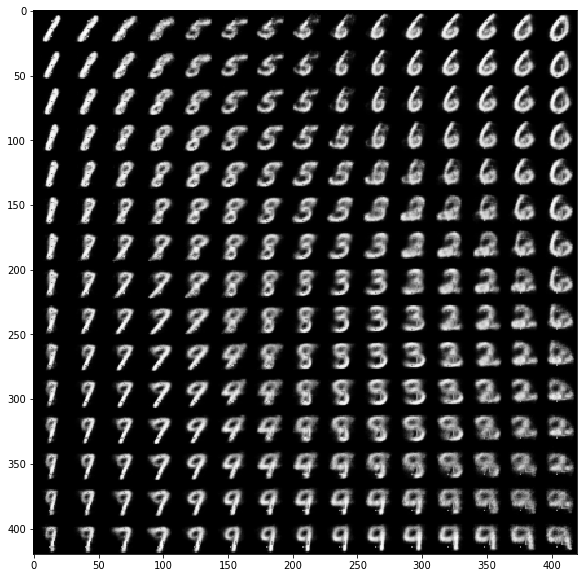

In [27]:
import matplotlib.pyplot as plt
from scipy.stats import norm

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])
    z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
    x_decoded = decoder.predict(z_sample, batch_size=batch_size)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size,
           j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize = (10, 10))
plt.imshow(figure, cmap="Greys_r")
plt.show()
  